## Death-Slot analysis - 2nd draw position Semi/Finals

In [1]:
import pandas as pd, numpy as np, seaborn as sbn, matplotlib.pyplot as plt

from Modules import utils as utl
from Modules import data_exploration as de
from Modules import machine_learning as ml

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm

In [35]:
from scipy.stats import zscore
from scipy.stats import ttest_ind

#### Load both cleaned CSV files and verify/ensure numeric draw positions

In [5]:
csv_finals_path = 'Data/finalists_cleaned.csv'
csv_semis_path = 'Data/semifinalists_cleaned.csv'

In [7]:
finals_df = utl.load_csv(csv_finals_path, skiprows=0, encoding='windows-1252')
semis_df = utl.load_csv(csv_semis_path, skiprows=0, encoding='windows-1252')

In [9]:
finals_df.isna().sum()

year                       0
final_draw_position        0
country                    0
style                      0
final_televote_points     32
final_jury_points         32
final_televote_votes     128
final_jury_votes         128
final_place                0
final_total_points         0
dtype: int64

In [11]:
semis_df.isna().sum()

year                      0
semi_final                0
semi_draw_position        0
country                   0
style                     0
semi_place                0
semi_televote_points    240
semi_jury_points        271
semi_total_points         0
dtype: int64

In [13]:
finals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   358 non-null    int64  
 1   final_draw_position    358 non-null    int64  
 2   country                358 non-null    object 
 3   style                  358 non-null    object 
 4   final_televote_points  326 non-null    float64
 5   final_jury_points      326 non-null    float64
 6   final_televote_votes   230 non-null    float64
 7   final_jury_votes       230 non-null    float64
 8   final_place            358 non-null    float64
 9   final_total_points     358 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 28.1+ KB


In [15]:
semis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  483 non-null    int64  
 1   semi_final            483 non-null    int64  
 2   semi_draw_position    483 non-null    int64  
 3   country               483 non-null    object 
 4   style                 483 non-null    object 
 5   semi_place            483 non-null    float64
 6   semi_televote_points  243 non-null    float64
 7   semi_jury_points      212 non-null    float64
 8   semi_total_points     483 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 34.1+ KB


#### EDA (Exploratory Data Analysis) - Does position 2 stand out? (We'll start with the finals)

In [17]:
draw_position_stats_finals = finals_df.groupby('final_draw_position')['final_place'].agg(['count', 'mean', 'median', 'std']).sort_index()

In [19]:
draw_position_stats_finals.loc[2]

count     14.000000
mean      19.500000
median    21.500000
std        5.229355
Name: 2, dtype: float64

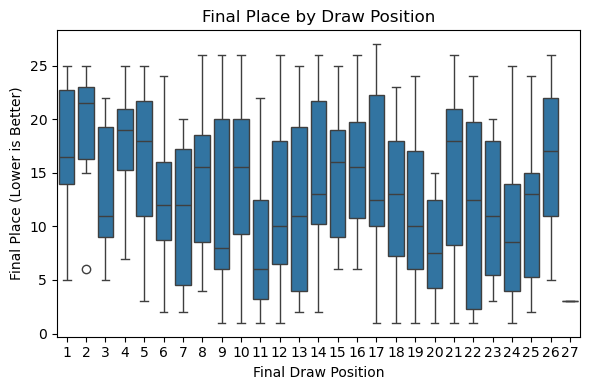

In [23]:
de.vs.boxplot(data=finals_df, x='final_draw_position', y='final_place', title='Final Place by Draw Position', 
              xlabel='Final Draw Position', ylabel='Final Place (Lower is Better)')

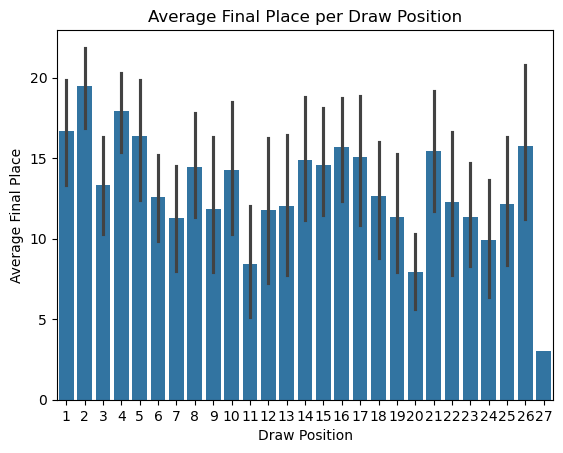

In [25]:
de.vs.barplot(finals_df, x_col='final_draw_position', y_col='final_place', agg_func='mean', 
              title='Average Final Place per Draw Position', 
              xlabel='Draw Position', ylabel='Average Final Place')

##### Important note: A year had 27 finalists, we will ignore the 27th draw position as not enough data exists to correctly analyse this.

##### From our draw position stats and our boxplot and barplot we now see the following:
- From 2009 to 2023 we correctly found 14 entries that performed in the 2nd draw position in the Eurovision finals.
- On average these entries placed 19.5 (mean), so around the 19th or 20th place, at the finals - which is not great.
- The median at 21.5, the middle-ranked entry after sorting, placed 21.5th - which, given that it's worse than the mean, suggests that entries performing at the 2nd draw position skew towards bad results.
- The STD (standard deviation) at 5.229 explains that most entries place within ±5 places of the mean (so roughly between 14th and 25th place)

The boxplot shows that the interquartile range (middle 50% of data) goes from roughly 16th to 23rd place. The median is correctly placed at 21.5 The whiskers are fairly narrow suggesting the data, outliers excluded, has limited range. And we have only 1 outlier at the 6th place, which is the best performance an entry at the 2nd draw position has achieved in the 2009-2023 timespan.
The box for 2nd position itself is the second smallest one suggesting low variability in performance, while also being the most upward box - so far confirming our hypothesis that the Death-Slot is a real thing. Other draw positions have similarly high medians, with greater variability but none quite as profound as the 2nd draw position.

The barplot shows us the overall performance of each draw position, and it's clear that 2nd position has had the worst (mean/average) performance with a fairly low standard error. At the same time we see that draw positions 11 and 20 appear to be the, on average, best performing draw positions. 

#### Attempt at testing our hypothesis and use z-scores to see if position 2 is itself an outlier in performance

In [37]:
draw_position_means_finals = draw_position_stats_finals['mean']
z_scores_finals = zscore(draw_position_means_finals)
position_2_z_finals = z_scores_finals[draw_position_stats_finals.index == 2]

In [43]:
z_scores_finals

final_draw_position
1     1.104056
2     1.944908
3     0.090722
4     1.470581
5     0.996255
6    -0.146442
7    -0.534527
8     0.414126
9    -0.362045
10    0.371006
11   -1.396939
12   -0.394385
13   -0.318924
14    0.543488
15    0.457247
16    0.802212
17    0.608169
18   -0.124881
19   -0.512967
20   -1.547861
21    0.715971
22   -0.232683
23   -0.512967
24   -0.944173
25   -0.275803
26    0.821377
27   -3.035523
Name: mean, dtype: float64

##### Computing z-scores of the mean final place for each draw position to see if 2 is "extreme"/stands out.
With 2nd draw position having a z-score of 1.944 it means that the average final place of entries starting at position 2 are nearly 2 standrad deviations worse than the overall average of all positions.
With 1.96 typically being enough to be considered statistically "extreme", we are very close. So while we can't say that 2nd draw position is an outlier by itself, it is clear that we have a strong indicator that Position 2 has one of the worst average placements. No other draw positions has a high or low a z-score as position 2 (ignoring 27).

In [39]:
position_2_finals = finals_df[finals_df['final_draw_position'] == 2]['final_place']
other_positions_finals = finals_df[finals_df['final_draw_position'] != 2]['final_place']

In [41]:
t_stat, p_val = ttest_ind(position_2_finals, other_positions_finals, equal_var=False)
print(f"T-statistic: {t_stat}, p-value: {p_val}")

T-statistic: 4.373910959104701, p-value: 0.0005284538015036808


##### T-Test of position 2 against all others
Using Welch's t-test, comparing position 2 versus all other draw positions, we get a p-value of just 0.0005 and a t-statistic of 4.373. 
The t-statistic indicates that the difference between the mean final placements of these two groups is approx. 4.4 standard errors apart, which is strong evidence of a meaningful difference. 
Our result when comparing position 2 to all other positions combined, is that we observe significantly worse average placement for postion 2. This must be taken with a slight grain of salt however as we are comparing entries at position 2 with entries from all other positions - creating an imbalance as we do know other draw positions have similar, if not as profound, disadvantages. However, this score is still significant enough that even compared against a field of positions, that we can say it is a worse draw position.

The p-value is very low. Our hypothesis being that starting at 2nd draw position aka the Death-Slot is signifanctly worse than any other draw position, this means our null hypothesis is that there is no difference. If the p-value is smaller than 0.05 that's ordinarily enough to reject the null hypothesis. Ours is much lower at just 0.0005, meaning that it is highly unlikely that entries starting at the 2nd draw position have performed badly by mere chance alone - strongly suggesting that the 2nd position does in fact performe statistically worse. 